## Pemeriksaan Kestasioneran Data


<ipython-input-1-c78b1d027ef0>:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start='1961-01', periods=len(data), freq='M')


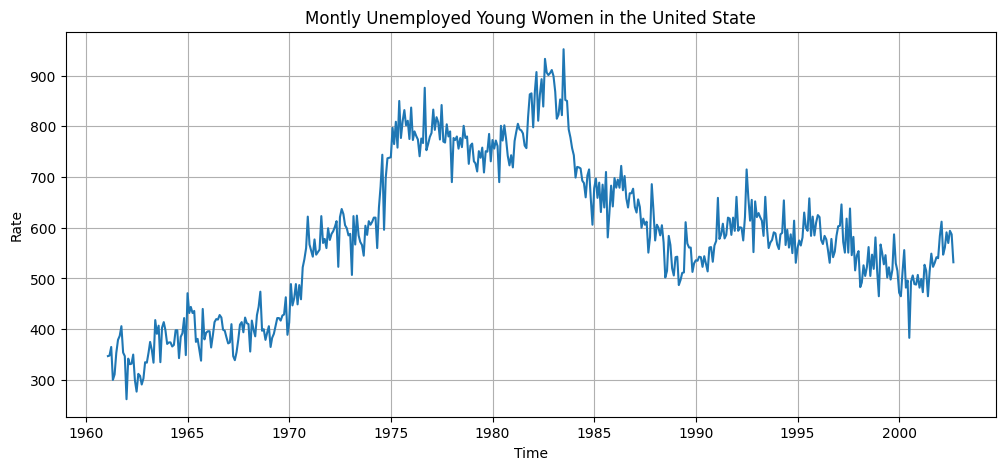

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam


# Ubah ke format time series

data = pd.read_excel('data1.xlsx')
data.index = pd.date_range(start='1961-01', periods=len(data), freq='M')

# Plot data asli
plt.figure(figsize=(12, 5))
plt.plot(data)
plt.title("Montly Unemployed Young Women in the United State")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

ADF Statistic: -2.043934037790816
p-value: 0.26764778182632143


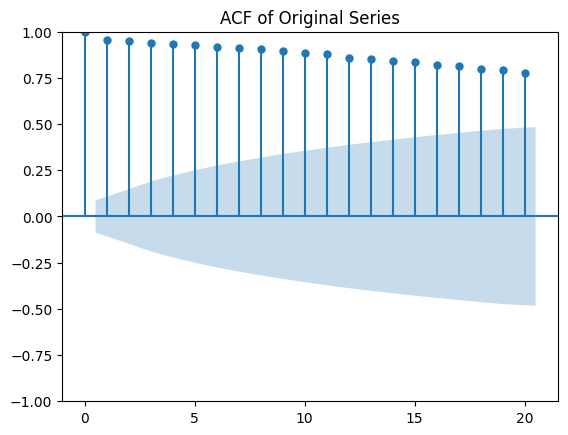

In [2]:
# Uji ADF untuk seluruh data
adf_result = adfuller(data)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

# Plot ACF untuk seluruh data
plot_acf(data, lags=20)
plt.title("ACF of Original Series")
plt.show()

## Dekomposisi

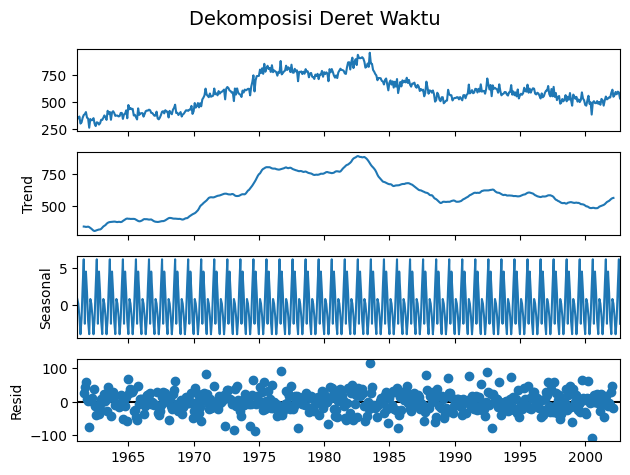

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Gunakan dekomposisi aditif (bisa juga 'multiplicative' jika pola musiman proporsional)
decompose_result = seasonal_decompose(data, model='additive', period=12)

# Plot hasil dekomposisi
decompose_result.plot()
plt.suptitle("Dekomposisi Deret Waktu", fontsize=14)
plt.tight_layout()
plt.show()

## Penanganan Ketaksioneran Data

In [4]:
#Diferensiasi untuk semua data
data_diff = data.diff().dropna()
adf_result_datadiff = adfuller(data_diff)
print(f"ADF Statistic setelah differencing: {adf_result_datadiff[0]}")
print(f"p-value: {adf_result_datadiff[1]}")

ADF Statistic setelah differencing: -5.724810664942231
p-value: 6.80988306120483e-07


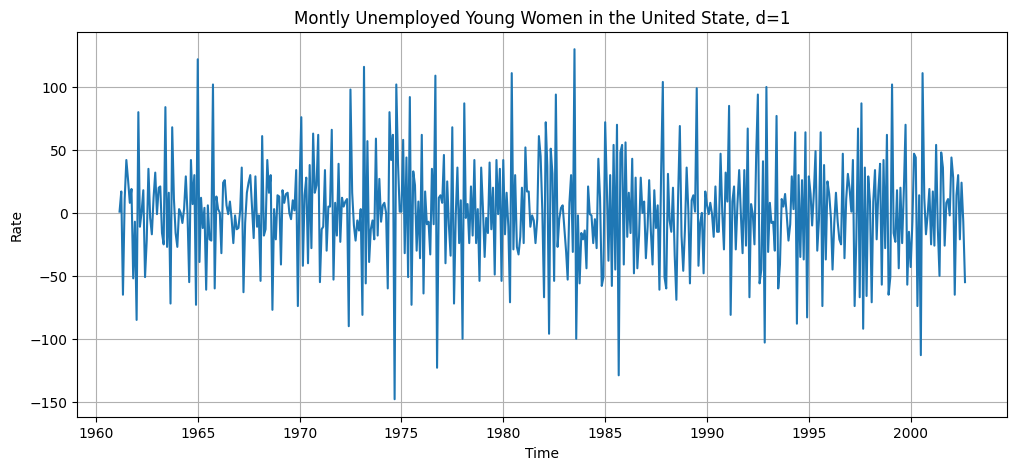

In [5]:
# Plot seluruh data setelah diff, d=1
plt.figure(figsize=(12, 5))
plt.plot(data_diff)
plt.title("Montly Unemployed Young Women in the United State, d=1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

## Materi Smoothing

In [6]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

# Simulasi 30 data penjualan bulanan (misalnya penjualan obat hewan)
data_smooth = {
    'Month': pd.date_range(start='2021-01-01', periods=30, freq='M'),
    'Sales': [
        120, 135, 150, 160, 145, 170, 180, 190, 200, 210,
        215, 220, 230, 225, 235, 245, 250, 260, 270, 265,
        275, 285, 290, 300, 310, 320, 325, 330, 340, 350
    ]
}

df = pd.DataFrame(data_smooth)
df.set_index('Month', inplace=True)


<ipython-input-6-7ffd4cf57f53>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'Month': pd.date_range(start='2021-01-01', periods=30, freq='M'),


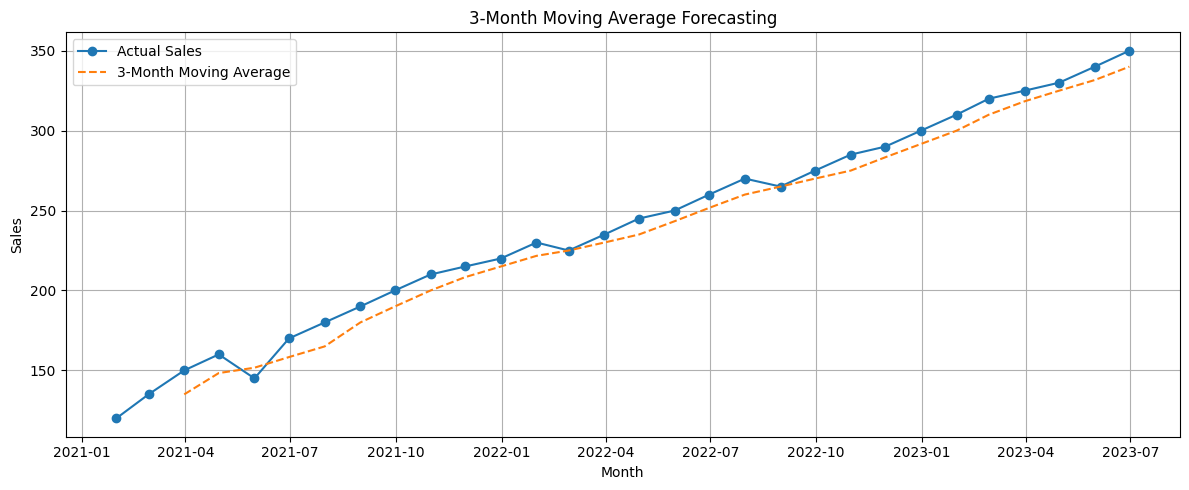

In [7]:
#Moving Average (3 Bulan)
df['MA_3'] = df['Sales'].rolling(window=3).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Actual Sales', marker='o')
plt.plot(df['MA_3'], label='3-Month Moving Average', linestyle='--')
plt.title('3-Month Moving Average Forecasting')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# Buat salinan list data awal
sales = list(df['Sales'])

# Forecast 3 bulan ke depan
ma_forecasts = []

for i in range(3):  # prediksi untuk bulan ke-31, 32, dan 33
    avg = sum(sales[-3:]) / 3
    ma_forecasts.append(avg)
    sales.append(avg)  # tambahkan prediksi sebagai data baru untuk prediksi selanjutnya

# Tampilkan hasil prediksi
for i, f in enumerate(ma_forecasts, start=1):
    print(f"Bulan ke-{30+i}: Prediksi = {f:.2f}")


Bulan ke-31: Prediksi = 340.00
Bulan ke-32: Prediksi = 343.33
Bulan ke-33: Prediksi = 344.44


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


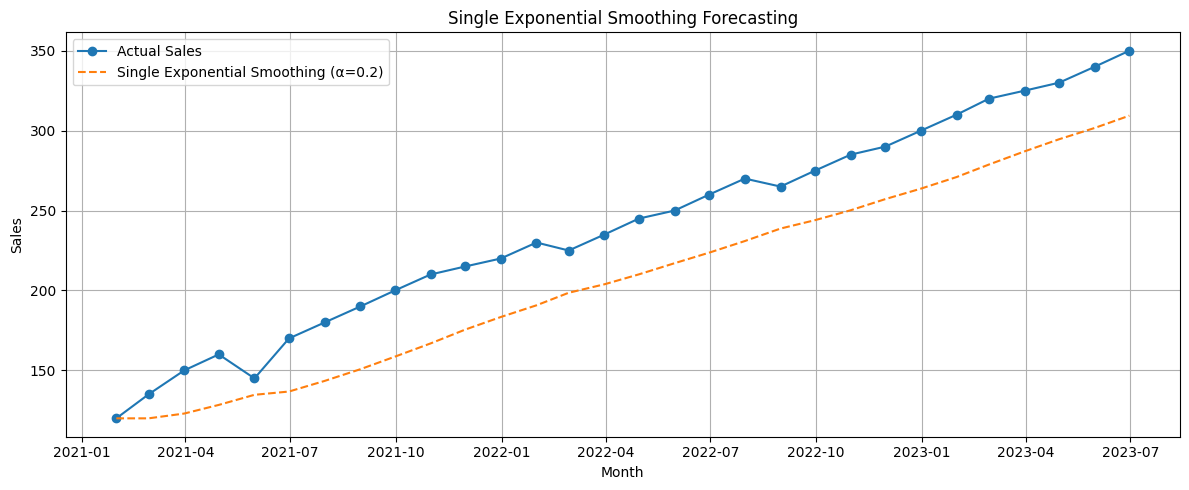

In [9]:
#Single Exponential Smoothing (α = 0.2)
model_ses = SimpleExpSmoothing(df['Sales']).fit(smoothing_level=0.2, optimized=False)
df['SES'] = model_ses.fittedvalues

plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Actual Sales', marker='o')
plt.plot(df['SES'], label='Single Exponential Smoothing (α=0.2)', linestyle='--')
plt.title('Single Exponential Smoothing Forecasting')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Forecast 3 bulan ke depan
ses_forecast = model_ses.forecast(steps=3)

# Tampilkan hasil
print("Forecast SES 3 bulan ke depan:")
print(ses_forecast)


Forecast SES 3 bulan ke depan:
2023-07-31    317.486105
2023-08-31    317.486105
2023-09-30    317.486105
Freq: ME, dtype: float64


<ipython-input-11-5aaf5cc32210>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


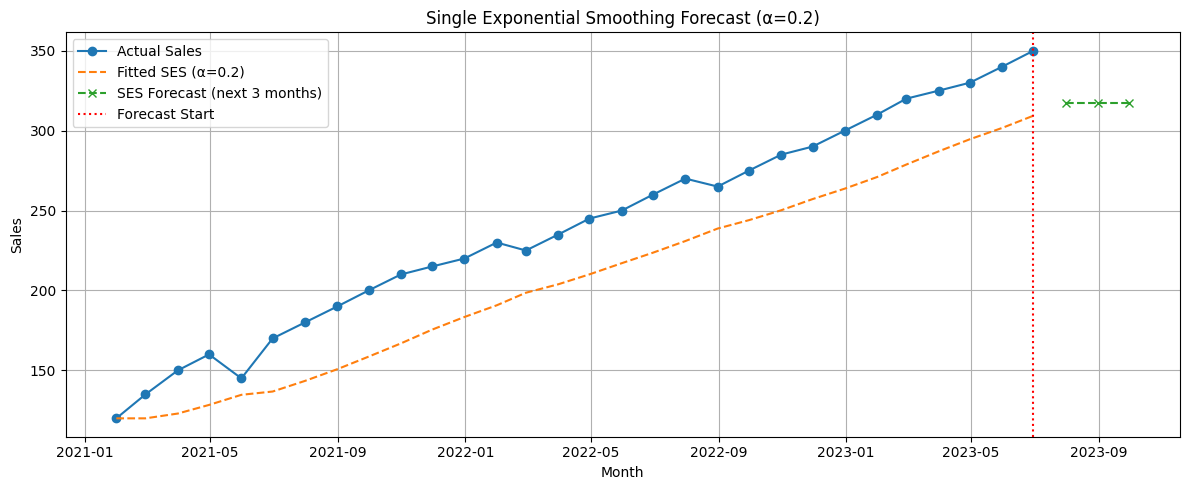

In [11]:
# Gabungkan hasil ke dalam DataFrame untuk visualisasi
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
forecast_series = pd.Series(ses_forecast.values, index=forecast_index)

plt.figure(figsize=(12,5))
plt.plot(df['Sales'], label='Actual Sales', marker='o')
plt.plot(model_ses.fittedvalues, label='Fitted SES (α=0.2)', linestyle='--')
plt.plot(forecast_series, label='SES Forecast (next 3 months)', marker='x', linestyle='--')
plt.axvline(x=df.index[-1], color='red', linestyle=':', label='Forecast Start')
plt.title('Single Exponential Smoothing Forecast (α=0.2)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-12-d5ad4de8966f>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2021-01-01', periods=30, freq='M')
<ipython-input-12-d5ad4de8966f>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


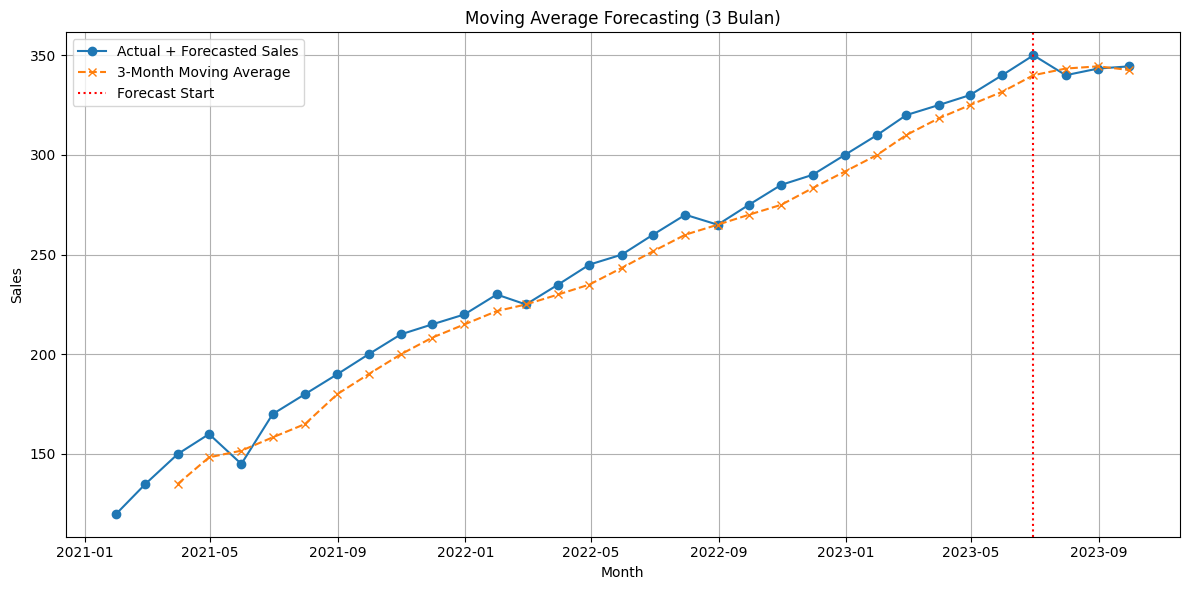

In [12]:
# 1. Data penjualan 30 bulan
sales_data = [
    120, 135, 150, 160, 145, 170, 180, 190, 200, 210,
    215, 220, 230, 225, 235, 245, 250, 260, 270, 265,
    275, 285, 290, 300, 310, 320, 325, 330, 340, 350
]

index = pd.date_range(start='2021-01-01', periods=30, freq='M')
df = pd.DataFrame({'Sales': sales_data}, index=index)

# 2. Hitung Moving Average 3 bulan untuk data aktual
df['MA_3'] = df['Sales'].rolling(window=3).mean()

# 3. Forecast 3 bulan ke depan dengan pendekatan Moving Average (recursive)
forecast_ma = []
last_3 = sales_data[-3:]  # Tiga data terakhir

for i in range(3):
    next_val = sum(last_3) / 3
    forecast_ma.append(next_val)
    last_3 = last_3[1:] + [next_val]  # Update untuk next forecast

# Buat tanggal untuk forecast
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
forecast_df = pd.DataFrame({'Sales': forecast_ma}, index=future_dates)

# Gabungkan semua data ke satu DataFrame
combined_df = pd.concat([df, forecast_df])

# Hitung MA_3 untuk data gabungan
combined_df['MA_3'] = combined_df['Sales'].rolling(window=3).mean()

# 4. Plot
plt.figure(figsize=(12,6))
plt.plot(combined_df.index, combined_df['Sales'], label='Actual + Forecasted Sales', marker='o')
plt.plot(combined_df.index, combined_df['MA_3'], label='3-Month Moving Average', linestyle='--', marker='x')
plt.axvline(x=df.index[-1], color='red', linestyle=':', label='Forecast Start')
plt.title('Moving Average Forecasting (3 Bulan)')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-13-44fb818a1f55>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2021-01-01', periods=30, freq='M')
<ipython-input-13-44fb818a1f55>:31: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


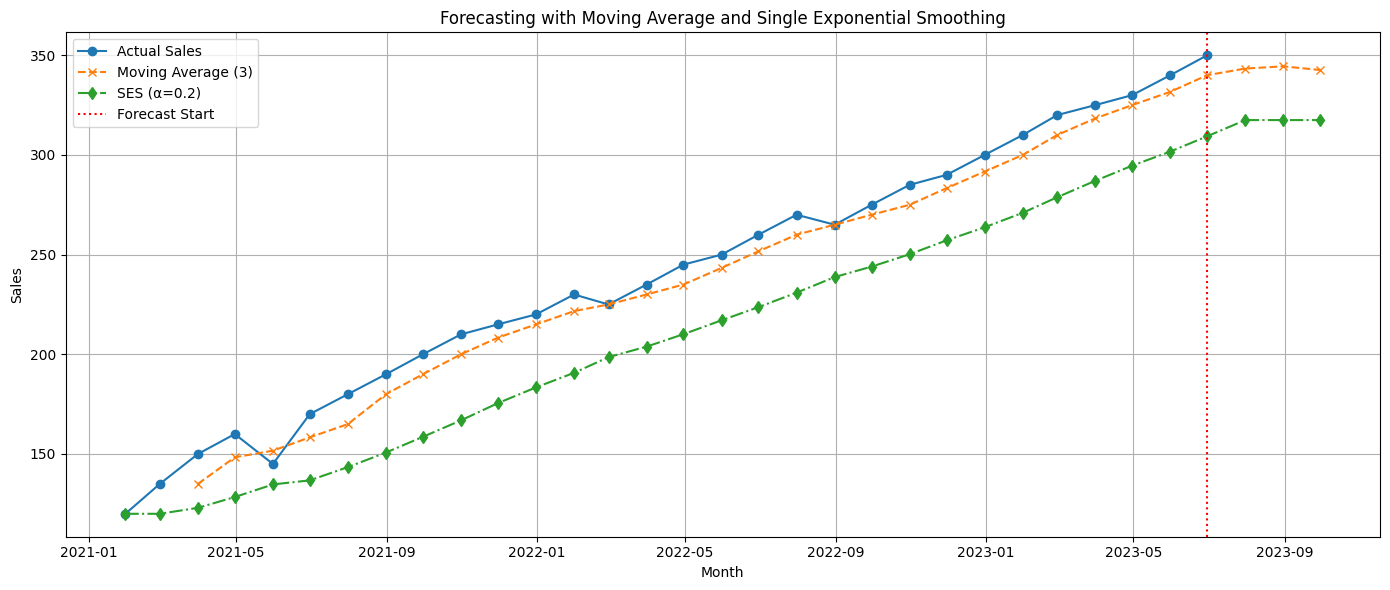

🔍 Evaluation Summary:

➡️ Moving Average (3)
   MAPE: 3.66%
   MAE : 8.21
   MSE : 79.37

➡️ Single Exponential Smoothing (α=0.2)
   MAPE: 14.54%
   MAE : 34.73
   MSE : 1248.04


In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==============================
# 1. Data Penjualan Bulanan
# ==============================
sales_data = [
    120, 135, 150, 160, 145, 170, 180, 190, 200, 210,
    215, 220, 230, 225, 235, 245, 250, 260, 270, 265,
    275, 285, 290, 300, 310, 320, 325, 330, 340, 350
]

index = pd.date_range(start='2021-01-01', periods=30, freq='M')
df = pd.DataFrame({'Sales': sales_data}, index=index)

# ==============================
# 2. Moving Average (MA-3)
# ==============================
df['MA_3'] = df['Sales'].rolling(window=3).mean()

# Forecast 3 bulan ke depan (recursive approach)
ma_forecast = []
last_3 = df['Sales'][-3:].tolist()

for _ in range(3):
    next_val = np.mean(last_3)
    ma_forecast.append(next_val)
    last_3 = last_3[1:] + [next_val]

# Extend DataFrame untuk MA forecast
future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
df_ma_forecast = pd.DataFrame({'Sales': ma_forecast}, index=future_index)
df_ma_full = pd.concat([df[['Sales', 'MA_3']], df_ma_forecast])
df_ma_full['MA_3'] = df_ma_full['Sales'].rolling(window=3).mean()

# ==============================
# 3. Single Exponential Smoothing (α=0.2)
# ==============================
ses_model = SimpleExpSmoothing(df['Sales']).fit(smoothing_level=0.2, optimized=False)
df['SES'] = ses_model.fittedvalues

# Forecast 3 bulan ke depan
ses_forecast = ses_model.forecast(3)
df_ses_forecast = pd.DataFrame({'SES': ses_forecast}, index=future_index)

# Gabungkan ke DataFrame
df_ses_full = pd.concat([df[['Sales', 'SES']], df_ses_forecast])

# ==============================
# 4. Evaluasi Akurasi (MAPE, MAE, MSE)
# ==============================
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MA-3: evaluasi dari titik ke-4 karena MA baru tersedia dari sana
ma_eval = df.dropna()
ma_mape = mean_absolute_percentage_error(ma_eval['Sales'], ma_eval['MA_3'])
ma_mae = mean_absolute_error(ma_eval['Sales'], ma_eval['MA_3'])
ma_mse = mean_squared_error(ma_eval['Sales'], ma_eval['MA_3'])

# SES: dari titik ke-2 (fit dimulai dari t=1)
ses_eval = df.dropna()
ses_mape = mean_absolute_percentage_error(ses_eval['Sales'], ses_eval['SES'])
ses_mae = mean_absolute_error(ses_eval['Sales'], ses_eval['SES'])
ses_mse = mean_squared_error(ses_eval['Sales'], ses_eval['SES'])

# ==============================
# 5. Plot Gabungan
# ==============================
plt.figure(figsize=(14,6))

# Plot data aktual
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o')

# Plot MA (historis dan forecast)
plt.plot(df_ma_full.index, df_ma_full['MA_3'], label='Moving Average (3)', linestyle='--', marker='x')

# Plot SES (historis dan forecast)
plt.plot(df_ses_full.index, df_ses_full['SES'], label='SES (α=0.2)', linestyle='-.', marker='d')

# Forecast line
plt.axvline(x=df.index[-1], color='red', linestyle=':', label='Forecast Start')

plt.title('Forecasting with Moving Average and Single Exponential Smoothing')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 6. Summary Evaluasi
# ==============================
print("🔍 Evaluation Summary:\n")
print("➡️ Moving Average (3)")
print(f"   MAPE: {ma_mape:.2f}%")
print(f"   MAE : {ma_mae:.2f}")
print(f"   MSE : {ma_mse:.2f}\n")

print("➡️ Single Exponential Smoothing (α=0.2)")
print(f"   MAPE: {ses_mape:.2f}%")
print(f"   MAE : {ses_mae:.2f}")
print(f"   MSE : {ses_mse:.2f}")


<ipython-input-14-c5d5890b6f1e>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index = pd.date_range(start='2021-01-01', periods=30, freq='M')
<ipython-input-14-c5d5890b6f1e>:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')


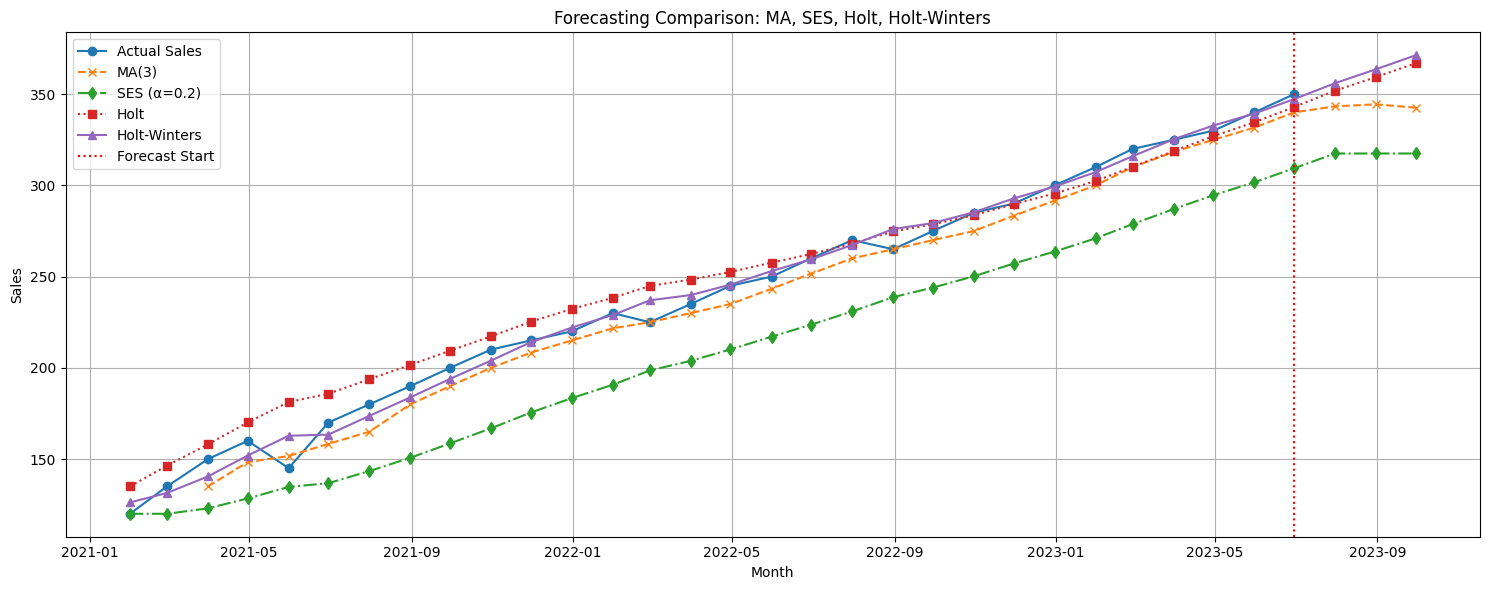


🔍 Evaluation Summary (in-sample):

➡️ MA
   MAPE: 3.66%
   MAE : 8.21
   MSE : 79.37

➡️ SES
   MAPE: 14.54%
   MAE : 34.73
   MSE : 1248.04

➡️ Holt
   MAPE: 4.40%
   MAE : 9.09
   MSE : 129.71

➡️ Holt-Winters
   MAPE: 2.26%
   MAE : 4.52
   MSE : 37.37



In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==========================================
# 1. DATA: Penjualan 30 bulan
# ==========================================
sales_data = [
    120, 135, 150, 160, 145, 170, 180, 190, 200, 210,
    215, 220, 230, 225, 235, 245, 250, 260, 270, 265,
    275, 285, 290, 300, 310, 320, 325, 330, 340, 350
]
index = pd.date_range(start='2021-01-01', periods=30, freq='M')
df = pd.DataFrame({'Sales': sales_data}, index=index)

# ==========================================
# 2. Moving Average (3 bulan)
# ==========================================
df['MA_3'] = df['Sales'].rolling(window=3).mean()

# Forecast 3 bulan ke depan (recursive MA)
ma_forecast = []
last_3 = df['Sales'][-3:].tolist()
for _ in range(3):
    next_val = np.mean(last_3)
    ma_forecast.append(next_val)
    last_3 = last_3[1:] + [next_val]
future_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='M')
df_ma_forecast = pd.DataFrame({'Sales': ma_forecast}, index=future_index)
df_ma_full = pd.concat([df[['Sales', 'MA_3']], df_ma_forecast])
df_ma_full['MA_3'] = df_ma_full['Sales'].rolling(window=3).mean()

# ==========================================
# 3. Single Exponential Smoothing (α = 0.2)
# ==========================================
ses_model = SimpleExpSmoothing(df['Sales']).fit(smoothing_level=0.2, optimized=False)
df['SES'] = ses_model.fittedvalues
ses_forecast = ses_model.forecast(3)
df_ses_forecast = pd.DataFrame({'SES': ses_forecast}, index=future_index)
df_ses_full = pd.concat([df[['Sales', 'SES']], df_ses_forecast])

# ==========================================
# 4. Holt’s Linear Trend Method
# ==========================================
holt_model = Holt(df['Sales']).fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False)
df['Holt'] = holt_model.fittedvalues
holt_forecast = holt_model.forecast(3)
df_holt_forecast = pd.DataFrame({'Holt': holt_forecast}, index=future_index)
df_holt_full = pd.concat([df[['Sales', 'Holt']], df_holt_forecast])

# ==========================================
# 5. Holt-Winters (Tanpa musiman)
# ==========================================
hw_model = ExponentialSmoothing(df['Sales'], trend='add', seasonal=None).fit()
df['HW'] = hw_model.fittedvalues
hw_forecast = hw_model.forecast(3)
df_hw_forecast = pd.DataFrame({'HW': hw_forecast}, index=future_index)
df_hw_full = pd.concat([df[['Sales', 'HW']], df_hw_forecast])

# ==========================================
# 6. EVALUASI AKURASI
# ==========================================
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = {}

# MA-3 (mulai dari indeks ke-3)
ma_eval = df.dropna()
results['MA'] = {
    'MAPE': mean_absolute_percentage_error(ma_eval['Sales'], ma_eval['MA_3']),
    'MAE': mean_absolute_error(ma_eval['Sales'], ma_eval['MA_3']),
    'MSE': mean_squared_error(ma_eval['Sales'], ma_eval['MA_3'])
}

# SES
ses_eval = df.dropna()
results['SES'] = {
    'MAPE': mean_absolute_percentage_error(ses_eval['Sales'], ses_eval['SES']),
    'MAE': mean_absolute_error(ses_eval['Sales'], ses_eval['SES']),
    'MSE': mean_squared_error(ses_eval['Sales'], ses_eval['SES'])
}

# Holt
holt_eval = df.dropna()
results['Holt'] = {
    'MAPE': mean_absolute_percentage_error(holt_eval['Sales'], holt_eval['Holt']),
    'MAE': mean_absolute_error(holt_eval['Sales'], holt_eval['Holt']),
    'MSE': mean_squared_error(holt_eval['Sales'], holt_eval['Holt'])
}

# Holt-Winters
hw_eval = df.dropna()
results['Holt-Winters'] = {
    'MAPE': mean_absolute_percentage_error(hw_eval['Sales'], hw_eval['HW']),
    'MAE': mean_absolute_error(hw_eval['Sales'], hw_eval['HW']),
    'MSE': mean_squared_error(hw_eval['Sales'], hw_eval['HW'])
}

# ==========================================
# 7. PLOT GABUNGAN
# ==========================================
plt.figure(figsize=(15,6))
plt.plot(df['Sales'], label='Actual Sales', marker='o')
plt.plot(df_ma_full['MA_3'], label='MA(3)', linestyle='--', marker='x')
plt.plot(df_ses_full['SES'], label='SES (α=0.2)', linestyle='-.', marker='d')
plt.plot(df_holt_full['Holt'], label='Holt', linestyle=':', marker='s')
plt.plot(df_hw_full['HW'], label='Holt-Winters', linestyle='-', marker='^')

plt.axvline(x=df.index[-1], color='red', linestyle=':', label='Forecast Start')
plt.title('Forecasting Comparison: MA, SES, Holt, Holt-Winters')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==========================================
# 8. CETAK RINGKASAN EVALUASI
# ==========================================
print("\n🔍 Evaluation Summary (in-sample):\n")
for model, metrics in results.items():
    print(f"➡️ {model}")
    print(f"   MAPE: {metrics['MAPE']:.2f}%")
    print(f"   MAE : {metrics['MAE']:.2f}")
    print(f"   MSE : {metrics['MSE']:.2f}\n")


## Pemodelan ARIMA

Panjang data training: 400
Panjang data testing: 100


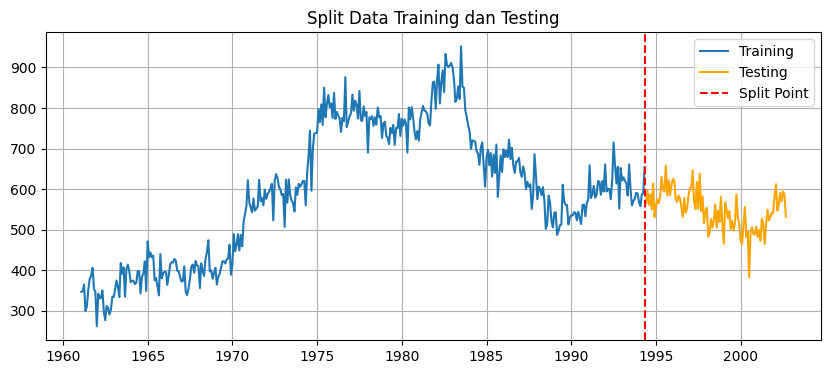

In [15]:
# data yang digunakan adalah dari file data1.xlsx
#Spliting data
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f"Panjang data training: {len(train)}")
print(f"Panjang data testing: {len(test)}")

# Visualisasi split
plt.figure(figsize=(10, 4))
plt.plot(train, label="Training")
plt.plot(test, label="Testing", color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Split Point')
plt.title("Split Data Training dan Testing")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
#Uji ADF
adf_result = adfuller(train)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

#Jika p-value > 0.05, maka data tidak stasioner dan perlu diferensiasi.

ADF Statistic: -1.9337768623799487
p-value: 0.3163419859712469


In [17]:
#Diferensiasi
train_diff = train.diff().dropna()
adf_result_diff = adfuller(train_diff)
print(f"ADF Statistic setelah differencing: {adf_result_diff[0]}")
print(f"p-value: {adf_result_diff[1]}")

ADF Statistic setelah differencing: -4.700081477822964
p-value: 8.412312502971929e-05


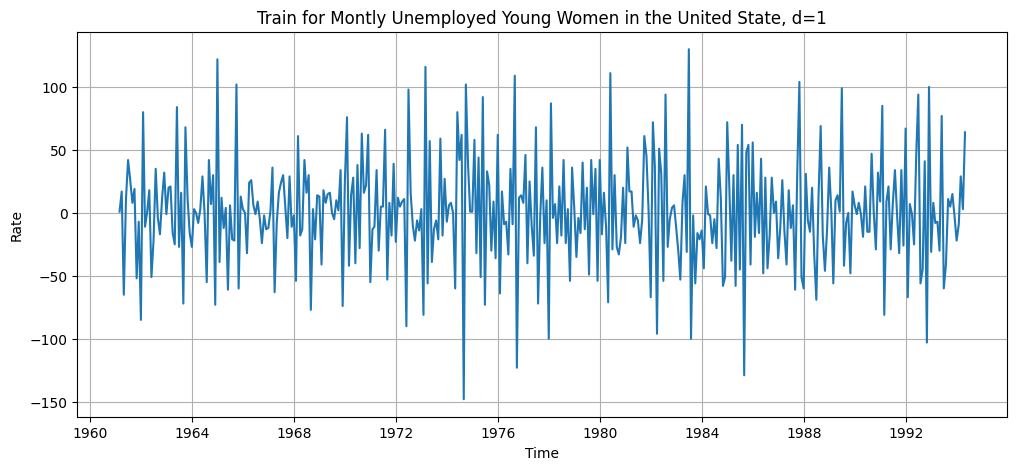

In [18]:
# Plot data train setelah diff
plt.figure(figsize=(12, 5))
plt.plot(train_diff)
plt.title("Train for Montly Unemployed Young Women in the United State, d=1")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

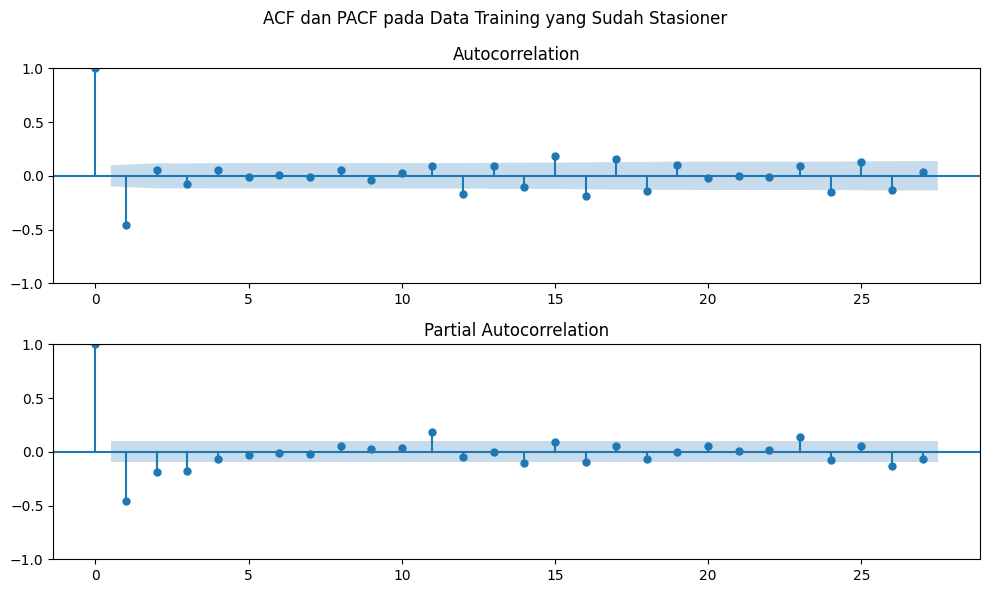

In [19]:
#Plot ACF dan PACF untuk identifikasi model

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(train_diff, ax=ax[0])
plot_pacf(train_diff, ax=ax[1])
plt.suptitle("ACF dan PACF pada Data Training yang Sudah Stasioner")
plt.tight_layout()
plt.show()

In [20]:
#Estimasi Model ARIMA pada Data Training

from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train, order=(0, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Un_Young_W   No. Observations:                  400
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2002.308
Date:                Wed, 21 May 2025   AIC                           4008.616
Time:                        04:40:56   BIC                           4016.594
Sample:                    01-31-1961   HQIC                          4011.775
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5776      0.037    -15.672      0.000      -0.650      -0.505
sigma2      1336.3917     82.761     16.148      0.000    1174.183    1498.600
Ljung-Box (L1) (Q):                   0.21   Jarque-

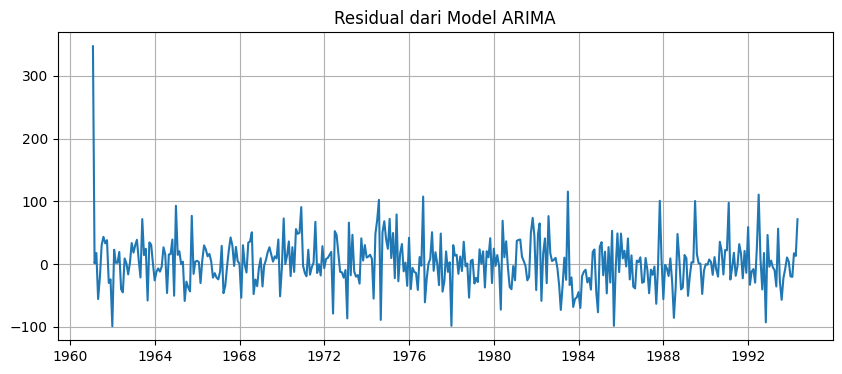

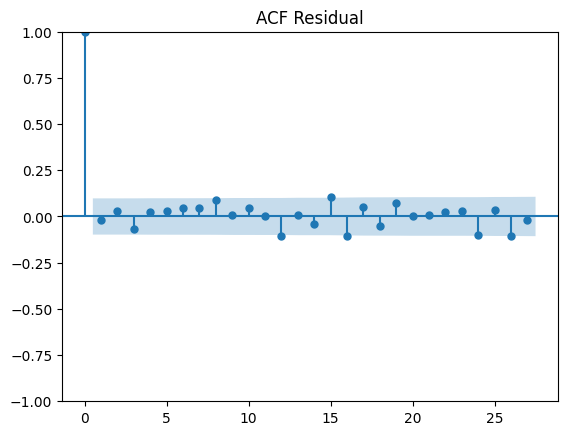

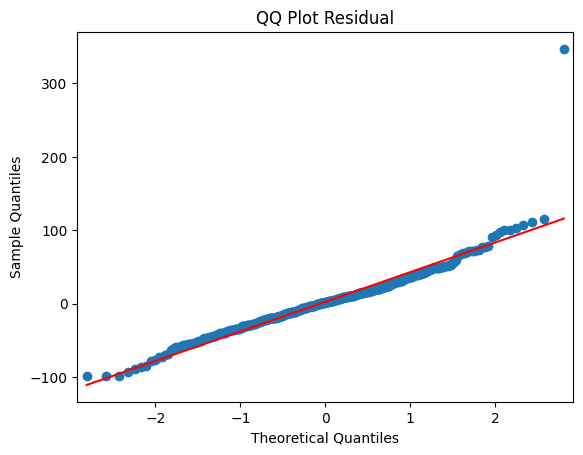

In [21]:
# Diagnostik Model
import statsmodels.api as sm

resid = model_fit.resid
# Plot Residual
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residual dari Model ARIMA")
plt.grid(True)
plt.show()

# ACF dari residual
plot_acf(resid)
plt.title("ACF Residual")
plt.show()

# QQ Plot
sm.qqplot(resid, line='s')
plt.title("QQ Plot Residual")
plt.show()

In [22]:
#Overfitting

model012 = ARIMA(train, order=(0, 1, 2))
model012_fit = model012.fit()
print(model012_fit.summary())

#Overfitting

model111 = ARIMA(train, order=(1, 1, 1))
model111_fit = model111.fit()
print(model111_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Un_Young_W   No. Observations:                  400
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -2002.109
Date:                Wed, 21 May 2025   AIC                           4010.219
Time:                        04:41:14   BIC                           4022.185
Sample:                    01-31-1961   HQIC                          4014.958
                         - 04-30-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5967      0.047    -12.640      0.000      -0.689      -0.504
ma.L2          0.0291      0.053      0.550      0.582      -0.075       0.133
sigma2      1335.0450     82.630     16.157      0.0

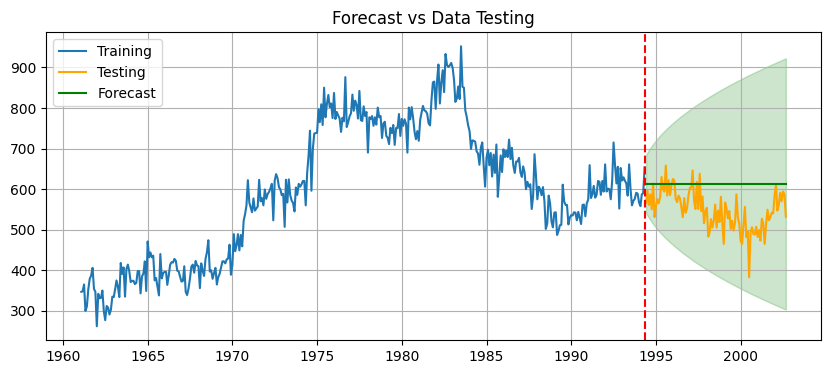

In [23]:
# Prediksi dan Evaluasi Model pada Data Testing
# Forecast untuk panjang data test
forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(train, label='Training')
plt.plot(test.index, test, label='Testing', color='orange')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='green', alpha=0.2)
plt.axvline(x=train.index[-1], color='red', linestyle='--')
plt.title("Forecast vs Data Testing")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Evaluasi akurasi model
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast_mean)
mae = mean_absolute_error(test, forecast_mean)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Hitung MAPE antara data testing dan hasil prediksi
mape = mean_absolute_percentage_error(test, forecast_mean)
print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

MAPE: 13.05%
MSE: 6348.37
MAE: 67.22


## Pemodelan SARIMA

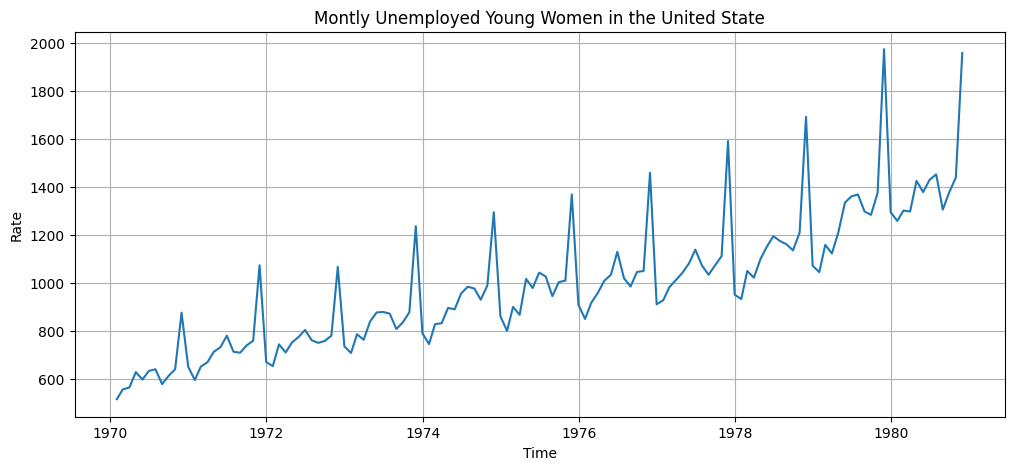

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ubah ke format time series
data2 = pd.read_excel('data2.xlsx')
data2.index = pd.date_range(start='1970-01', periods=len(data2), freq='ME')

# Plot data asli
plt.figure(figsize=(12, 5))
plt.plot(data2)
plt.title("Montly Unemployed Young Women in the United State")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()


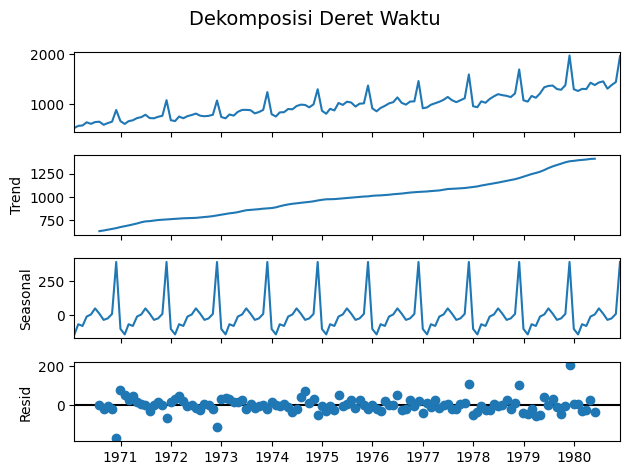

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Gunakan dekomposisi aditif (bisa juga 'multiplicative' jika pola musiman proporsional)
decompose_result = seasonal_decompose(data2, model='additive', period=12)

# Plot hasil dekomposisi
decompose_result.plot()
plt.suptitle("Dekomposisi Deret Waktu", fontsize=14)
plt.tight_layout()
plt.show()

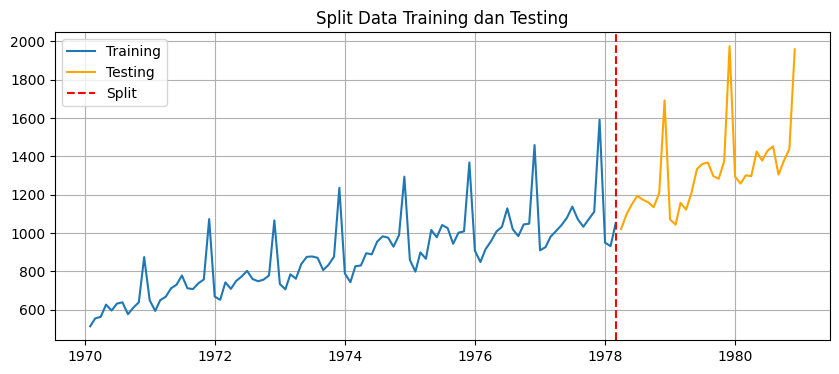

In [27]:
# Spliting Data
train2_size = int(len(data2) * 0.75)
train2, test2 = data2[:train2_size], data2[train2_size:]

plt.figure(figsize=(10, 4))
plt.plot(train2, label='Training')
plt.plot(test2, label='Testing', color='orange')
plt.axvline(train2.index[-1], color='red', linestyle='--', label='Split')
plt.legend()
plt.title("Split Data Training dan Testing")
plt.grid(True)
plt.show()

In [28]:
# Uji ADF
from statsmodels.tsa.stattools import adfuller

adf_train2 = adfuller(train2)
print(f"ADF Statistic: {adf_train2[0]}")
print(f"p-value: {adf_train2[1]}")

ADF Statistic: -2.300420775885529
p-value: 0.17183229883260248


In [29]:
# Differencing non-musiman
train2diff1 = train2.diff().dropna()
# ADF Test setelah differencing
adf_train2_diff1 = adfuller(train2diff1)
print(f"ADF Statistic d=1: {adf_train2_diff1[0]}")
print(f"p-value: {adf_train2_diff1[1]}")

ADF Statistic d=1: -3.7844734235129445
p-value: 0.003070227444916788


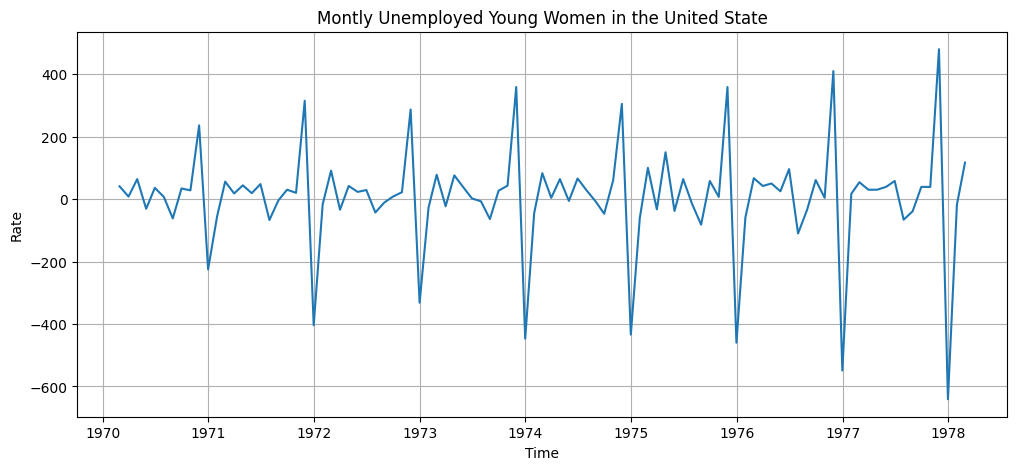

In [30]:
# Plot data training setelah differencing d=1
plt.figure(figsize=(12, 5))
plt.plot(train2diff1)
plt.title("Montly Unemployed Young Women in the United State")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.grid(True)
plt.show()

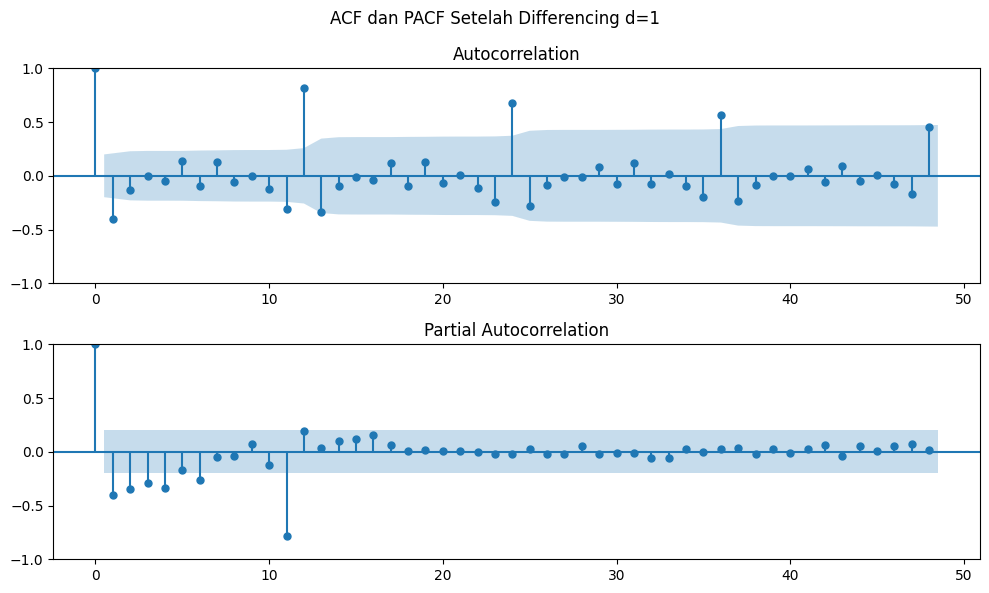

In [31]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(train2diff1, lags=48, ax=ax[0])
plot_pacf(train2diff1, lags=48, ax=ax[1])
plt.suptitle("ACF dan PACF Setelah Differencing d=1")
plt.tight_layout()
plt.show()

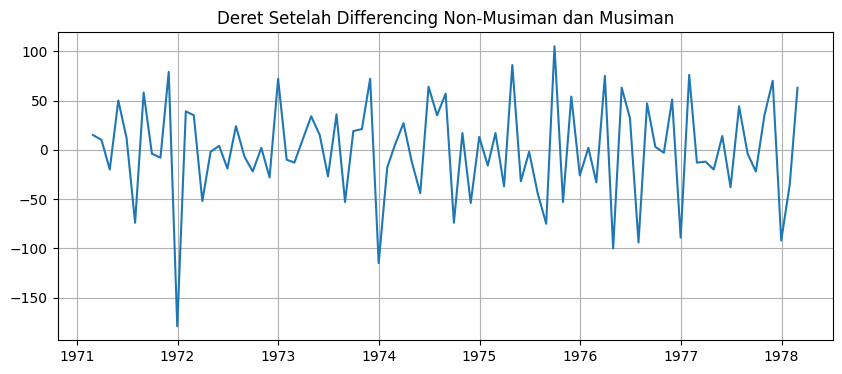

ADF setelah differencing: 6.2964460239622975e-12


In [32]:
periode_musiman = 12
# Differencing Non-Musiman dan Musiman
# Differencing non-musiman
#train2diff1 = train2.diff().dropna() -- sudah dilakukan

# Differencing musiman
seasonal_diff = train2.diff(periode_musiman).dropna()

# Gabungan keduanya
diff_combined = train2.diff().diff(periode_musiman).dropna()

plt.figure(figsize=(10, 4))
plt.plot(diff_combined)
plt.title("Deret Setelah Differencing Non-Musiman dan Musiman")
plt.grid(True)
plt.show()

# ADF Test setelah differencing
print("ADF setelah differencing:", adfuller(diff_combined)[1])

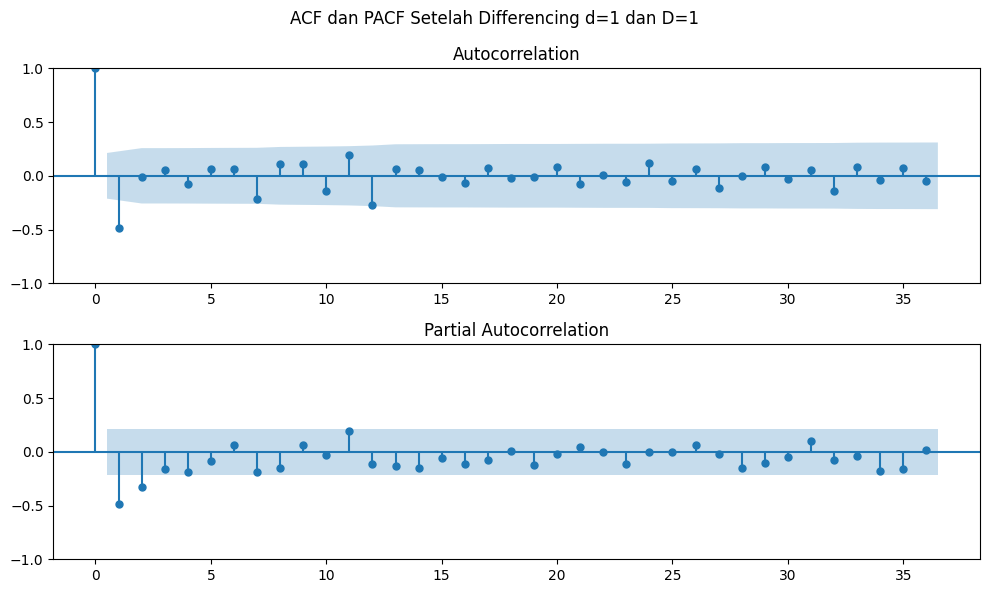

In [33]:
# Plot ACF dan PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(diff_combined, lags=36, ax=ax[0])
plot_pacf(diff_combined, lags=36, ax=ax[1])
plt.suptitle("ACF dan PACF Setelah Differencing d=1 dan D=1")
plt.tight_layout()
plt.show()

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(train2,
                order=(0,1,1),
                seasonal_order=(0,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit_sarima = model_sarima.fit()
print(model_fit_sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                580   No. Observations:                   98
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -355.710
Date:                            Wed, 21 May 2025   AIC                            717.421
Time:                                    04:42:10   BIC                            724.209
Sample:                                01-31-1970   HQIC                           720.120
                                     - 02-28-1978                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7760      0.094     -8.234      0.000      -0.961      -0.591
ma.S.L12      -0.3047      0.113   

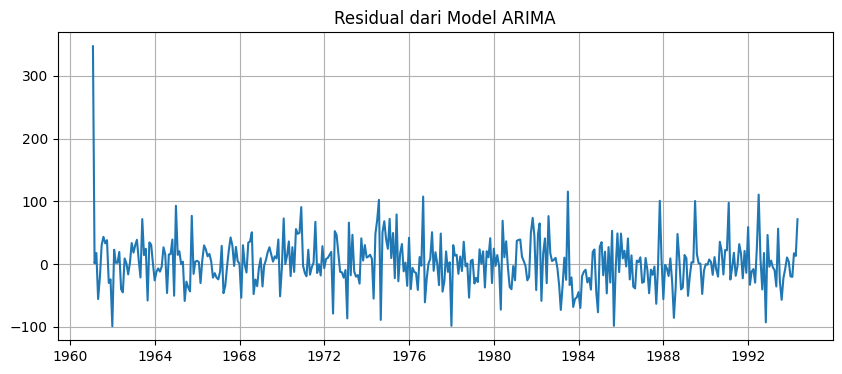

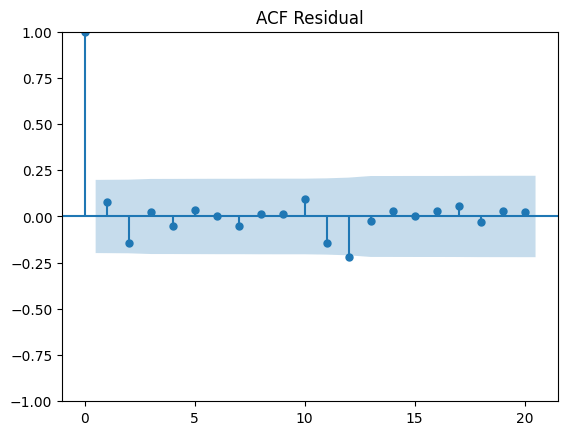

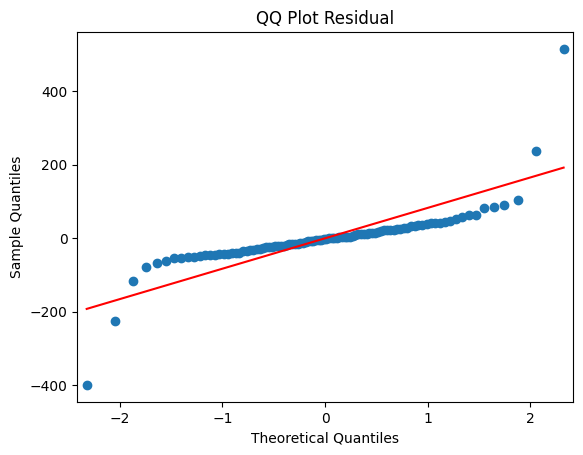

In [35]:
# Diagnostik Model
import statsmodels.api as sm

resid_sarima= model_fit_sarima.resid
# Plot Residual
plt.figure(figsize=(10, 4))
plt.plot(resid)
plt.title("Residual dari Model ARIMA")
plt.grid(True)
plt.show()

# ACF dari residual
plot_acf(resid_sarima)
plt.title("ACF Residual")
plt.show()

# QQ Plot
sm.qqplot(resid_sarima, line='s')
plt.title("QQ Plot Residual")
plt.show()

## Forecasting dengan Deep Learning

In [37]:
#data yang digunakan dari data1.xlsx
values = data['Un_Young_W'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(values)

In [38]:
# Sliding window (lag)
def create_dataset(series, lag):
    X, y = [], []
    for i in range(len(series) - lag):
        X.append(series[i:i+lag])
        y.append(series[i+lag])
    return np.array(X), np.array(y)

lag = 12
X, y = create_dataset(data_scaled, lag)
X = X.reshape((X.shape[0], lag, 1))

In [39]:
# Split data train/test
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [40]:
# Model LSTM
model_lstm = Sequential([
    LSTM(32, activation='relu', input_shape=(lag, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.01), loss='mse')
model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

# Model GRU
model_gru = Sequential([
    GRU(32, activation='relu', input_shape=(lag, 1)),
    Dense(1)
])
model_gru.compile(optimizer=Adam(0.01), loss='mse')
model_gru.fit(X_train, y_train, epochs=100, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
MAPE_LSTM: 6.12%
MSE_LSTM: 1709.90
MAE_LSTM: 33.82
MAPE_GRU: 5.69%
MSE_GRU: 1452.84
MAE_GRU: 31.18


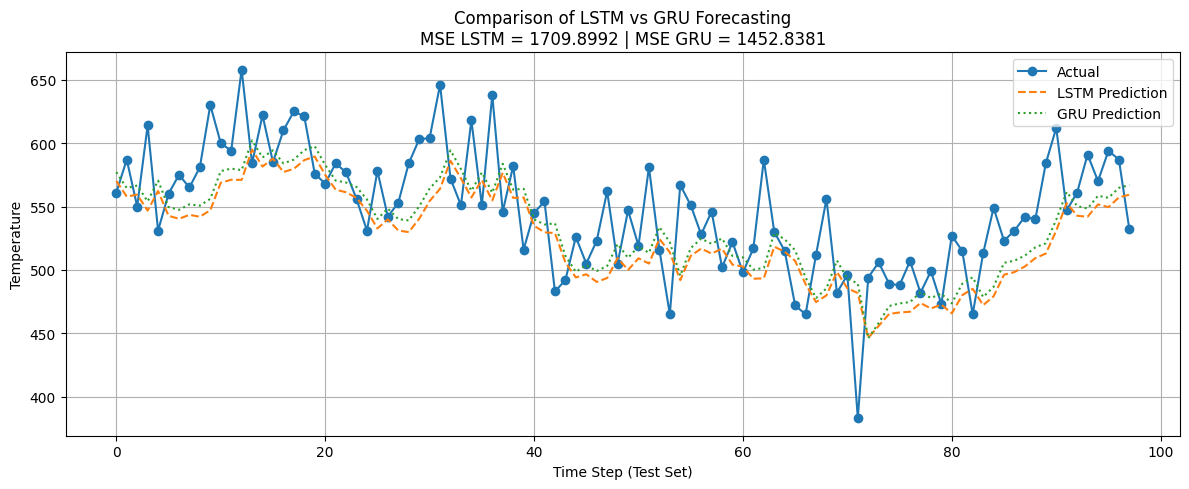

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prediksi & evaluasi
y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_pred_gru_inv = scaler.inverse_transform(y_pred_gru)

mse_lstm = mean_squared_error(y_test_inv, y_pred_lstm_inv)
mse_gru = mean_squared_error(y_test_inv, y_pred_gru_inv)

mae_lstm = mean_absolute_error(y_test_inv, y_pred_lstm_inv)
mae_gru = mean_absolute_error(y_test_inv, y_pred_gru_inv)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_lstm = mean_absolute_percentage_error(y_test_inv, y_pred_lstm_inv)
mape_gru = mean_absolute_percentage_error(y_test_inv, y_pred_gru_inv)

print(f"MAPE_LSTM: {mape_lstm:.2f}%")
print(f"MSE_LSTM: {mse_lstm:.2f}")
print(f"MAE_LSTM: {mae_lstm:.2f}")

print(f"MAPE_GRU: {mape_gru:.2f}%")
print(f"MSE_GRU: {mse_gru:.2f}")
print(f"MAE_GRU: {mae_gru:.2f}")

# Visualisasi hasil
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual', marker='o')
plt.plot(y_pred_lstm_inv, label='LSTM Prediction', linestyle='--')
plt.plot(y_pred_gru_inv, label='GRU Prediction', linestyle=':')
plt.title(f"Comparison of LSTM vs GRU Forecasting\nMSE LSTM = {mse_lstm:.4f} | MSE GRU = {mse_gru:.4f}")
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()